<a href="https://colab.research.google.com/github/2019mohamed/Team3-Project/blob/master/Arabic%20and%20English%20image%20caption/Pretrain_Arabic_English_caption_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
top_k = 5000
vocab_size = top_k + 1
#num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        C = tf.keras.initializers.Constant
        w1, w2 = [np.load("layer_%s_%s_weights_%s.npy" %(0, "dense", j)) \
                                      for j in range(2)]
        self.fc = tf.keras.layers.Dense(embedding_dim, kernel_initializer=C(w1), bias_initializer=C(w2))

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        C = tf.keras.initializers.Constant
        w1, w2, w3, w4, w5, w6 = [np.load("layer_%s_%s_weights_%s.npy" %(4, "bahdanau_attention", j)) \
                                  for j in range(6)]
        self.W1 = tf.keras.layers.Dense(units, kernel_initializer=C(w1), bias_initializer=C(w2))
        self.W2 = tf.keras.layers.Dense(units, kernel_initializer=C(w3), bias_initializer=C(w4))
        self.V = tf.keras.layers.Dense(1, kernel_initializer=C(w5), bias_initializer=C(w6))

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        C = tf.keras.initializers.Constant
        w_emb = np.load("layer_%s_%s_weights_%s.npy" %(0, "embedding", 0))
        w_gru_1, w_gru_2, w_gru_3 = [np.load("layer_%s_%s_weights_%s.npy" %(1, "gru", j)) for j in range(3)]
        w1, w2 = [np.load("layer_%s_%s_weights_%s.npy" %(2, "dense_1", j)) for j in range(2)]
        w3, w4 = [np.load("layer_%s_%s_weights_%s.npy" %(3, "dense_2", j)) for j in range(2)]

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, embeddings_initializer=C(w_emb))
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       kernel_initializer=C(w_gru_1),
                                       recurrent_initializer=C(w_gru_2),
                                       bias_initializer=C(w_gru_3)
                                       )
        self.fc1 = tf.keras.layers.Dense(self.units, kernel_initializer=C(w1), bias_initializer=C(w2))
        self.fc2 = tf.keras.layers.Dense(vocab_size, kernel_initializer=C(w3), bias_initializer=C(w4))

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
import pickle
with open('tokenizer (1).pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
max_length = 48
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

Prediction Caption: a bunch of a boy walking down a sidewalk and with a walk a brown skirt <end>


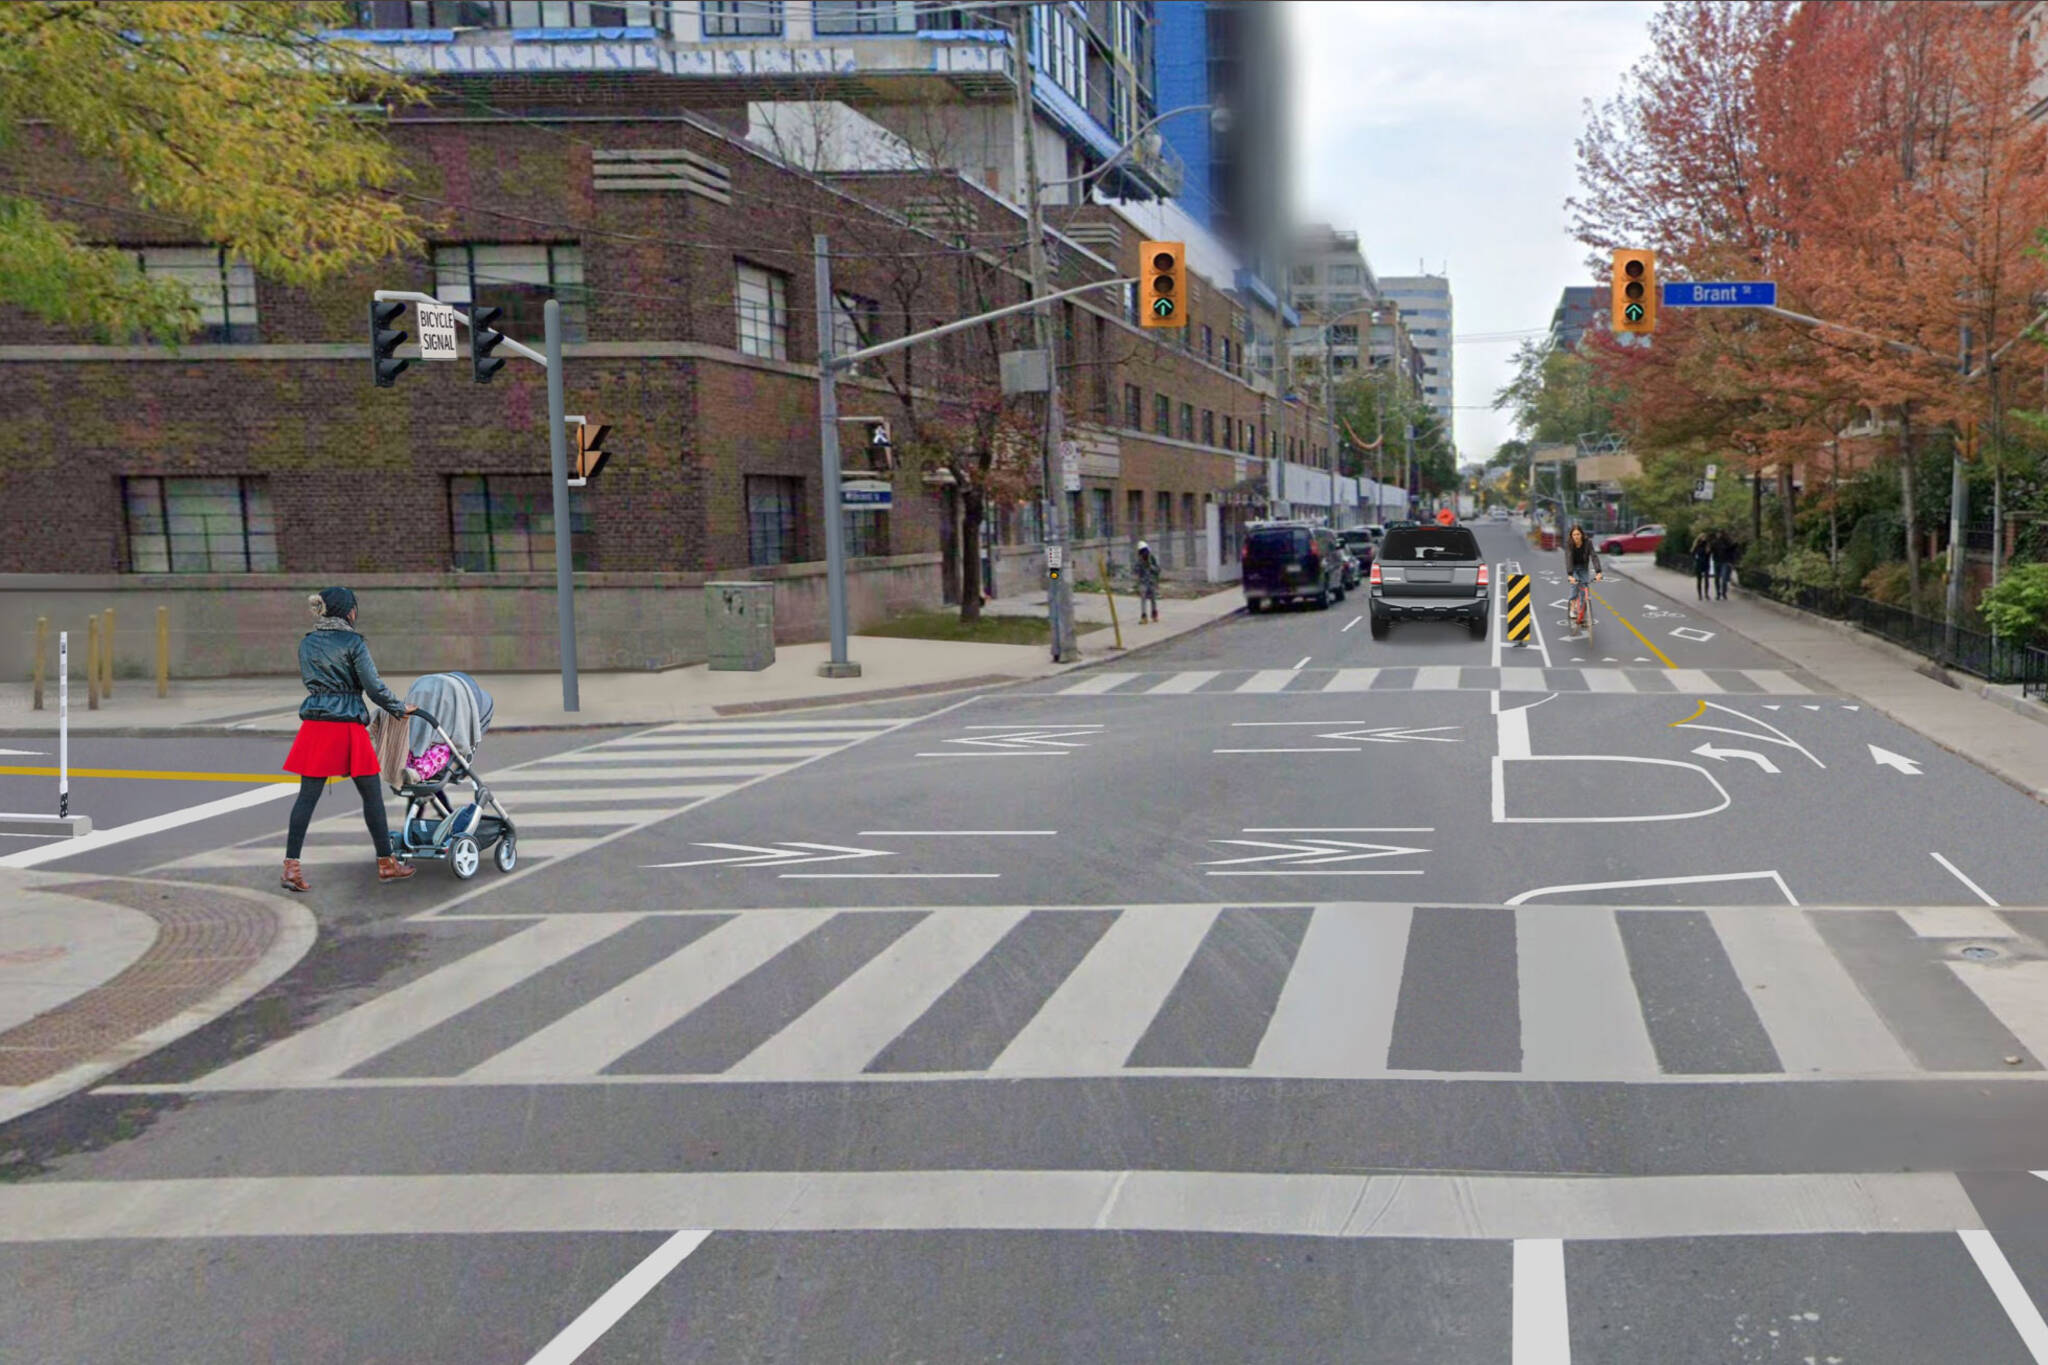

In [ ]:
image_url = 'street.jpg'
#image_extension = image_url[-4:]
#image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_url)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image_url, result, attention_plot)
# opening the image
Image.open(image_url)

In [ ]:
!pip install -U deep-translator

     |████████████████████████████████| 97 kB 4.0 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.3 which is incompatible.


In [ ]:
from deep_translator import GoogleTranslator
print(" ".join(result).replace('<end>',''))
res = " ".join(result).replace('<end>','')
translated = GoogleTranslator(source='en', target='ar').translate(res)
print(translated)

a bunch of a boy walking down a sidewalk and with a walk a brown skirt 
حفنة من صبي يسير على الرصيف ويمشي مع تنورة بنية اللون


In [ ]:
!pip install gTTS

In [ ]:
from gtts import gTTS
from IPython.display import display, Audio

myobj = gTTS(text=res, lang='en', slow=False)
myobj.save("en.mp3")
display(Audio("en.mp3",autoplay=True))